# 49. Overlapチャンク評価（40万件規模）

## 目的
- 実験47では5000件規模でOverlapフィルタが機能しなかった（Step1候補 = 全件）
- 40万件規模で再評価し、Overlapフィルタの効果を検証
- 64 bits / 96 bits の両方で最適なOverlap設定を探索

## 使用データ
- `data/wikipedia_400k_e5_base_embeddings.npy` - 埋め込みベクトル (399,029件)
- `data/itq_e5_base_64bits.pkl` - ITQモデル (64 bits)
- `data/itq_e5_base_96bits.pkl` - ITQモデル (96 bits)
- `data/wikipedia_400k_e5_base_hashes_*.npy` - 事前計算済みハッシュ

## 評価指標
- Recall@10（候補100/500/1000/5000件）
- Step1候補数と削減率
- 処理時間

## 0. セットアップ

In [2]:
import numpy as np
import time
from pathlib import Path
from tqdm import tqdm
import sys
sys.path.insert(0, '../src')
from itq_lsh import ITQLSH, hamming_distance_batch

DATA_DIR = Path("../data")
np.random.seed(42)

In [3]:
# データロード
print("Loading data...")
start_time = time.time()

embeddings = np.load(DATA_DIR / "wikipedia_400k_e5_base_embeddings.npy")
hashes_64 = np.load(DATA_DIR / "wikipedia_400k_e5_base_hashes_64bits.npy")
hashes_96 = np.load(DATA_DIR / "wikipedia_400k_e5_base_hashes_96bits.npy")

print(f"Embeddings: {embeddings.shape}")
print(f"Hashes 64 bits: {hashes_64.shape}")
print(f"Hashes 96 bits: {hashes_96.shape}")
print(f"Load time: {time.time() - start_time:.1f}s")

Loading data...
Embeddings: (399029, 768)
Hashes 64 bits: (399029, 64)
Hashes 96 bits: (399029, 96)
Load time: 0.2s


In [4]:
# ITQモデルロード
itq_64 = ITQLSH.load(str(DATA_DIR / "itq_e5_base_64bits.pkl"))
itq_96 = ITQLSH.load(str(DATA_DIR / "itq_e5_base_96bits.pkl"))
print(f"ITQ 64 bits: {itq_64.n_bits} bits")
print(f"ITQ 96 bits: {itq_96.n_bits} bits")

ITQ 64 bits: 64 bits
ITQ 96 bits: 96 bits


## 1. ヘルパー関数

In [5]:
def bits_to_bytes(bits: np.ndarray) -> np.ndarray:
    """ビット配列をバイト配列に変換（8ビット単位でパック）"""
    n_samples, n_bits = bits.shape
    # 8の倍数にパディング
    n_bytes = (n_bits + 7) // 8
    padded_bits = np.zeros((n_samples, n_bytes * 8), dtype=np.uint8)
    padded_bits[:, :n_bits] = bits
    # パック
    return np.packbits(padded_bits, axis=1)

def hash_to_overlap_segments(hash_bytes: np.ndarray, segment_width: int = 8, stride: int = 4):
    """
    ハッシュをオーバーラップするセグメントに分割
    
    Args:
        hash_bytes: バイト配列 (n_samples, n_bytes)
        segment_width: セグメント幅（ビット）
        stride: ストライド（ビット）
    
    Returns:
        segments: (n_samples, n_segments) の整数配列
    """
    n_samples, n_bytes = hash_bytes.shape
    n_bits = n_bytes * 8
    
    # バイトをビットに展開
    bits = np.unpackbits(hash_bytes, axis=1)
    
    # セグメント数
    n_segments = (n_bits - segment_width) // stride + 1
    
    segments = []
    for i in range(n_segments):
        start = i * stride
        end = start + segment_width
        # セグメントを整数に変換
        seg_bits = bits[:, start:end]
        seg_int = np.packbits(seg_bits, axis=1)
        if segment_width <= 8:
            segments.append(seg_int[:, 0])
        elif segment_width <= 16:
            segments.append((seg_int[:, 0].astype(np.uint16) << 8) | seg_int[:, 1])
        else:
            # 16ビット超の場合はタプルで
            segments.append(seg_int)
    
    return np.array(segments).T  # (n_samples, n_segments)

def overlap_filter_step1(query_segments, doc_segments):
    """
    Step1: いずれかのセグメントが一致するドキュメントを候補として抽出
    
    Returns:
        candidate_indices: 候補ドキュメントのインデックス
    """
    n_docs, n_segments = doc_segments.shape
    
    # 各セグメントで一致を確認
    matches = np.zeros(n_docs, dtype=bool)
    for seg_idx in range(n_segments):
        matches |= (doc_segments[:, seg_idx] == query_segments[seg_idx])
    
    return np.where(matches)[0]

In [6]:
def evaluate_overlap_config(
    embeddings: np.ndarray,
    hashes: np.ndarray,
    itq_model: ITQLSH,
    segment_width: int,
    stride: int,
    n_queries: int = 100,
    top_k: int = 10,
    candidate_limits: list = [100, 500, 1000, 5000]
):
    """
    Overlap設定を評価
    
    Returns:
        results: 評価結果の辞書
    """
    n_docs = len(embeddings)
    
    # ハッシュをバイト配列に変換
    hash_bytes = bits_to_bytes(hashes)
    
    # セグメントに分割
    doc_segments = hash_to_overlap_segments(hash_bytes, segment_width, stride)
    n_segments = doc_segments.shape[1]
    
    # クエリをランダムに選択
    query_indices = np.random.choice(n_docs, n_queries, replace=False)
    
    # Ground truth計算（コサイン類似度でTop-K）
    print(f"  Computing ground truth for {n_queries} queries...")
    ground_truth = []
    for q_idx in tqdm(query_indices, desc="  Ground truth"):
        sims = embeddings @ embeddings[q_idx]
        sims[q_idx] = -1  # 自分自身を除外
        top_indices = np.argsort(sims)[-top_k:][::-1]
        ground_truth.append(set(top_indices))
    
    # 評価
    step1_candidates_list = []
    recalls = {limit: [] for limit in candidate_limits}
    
    print(f"  Evaluating overlap filter...")
    for i, q_idx in enumerate(tqdm(query_indices, desc="  Queries")):
        query_segments = doc_segments[q_idx]
        
        # Step1: Overlapフィルタ
        candidates = overlap_filter_step1(query_segments, doc_segments)
        candidates = candidates[candidates != q_idx]  # 自分自身を除外
        step1_candidates_list.append(len(candidates))
        
        if len(candidates) == 0:
            for limit in candidate_limits:
                recalls[limit].append(0.0)
            continue
        
        # Step2: ハミング距離でソート
        query_hash = hashes[q_idx]
        candidate_hashes = hashes[candidates]
        distances = hamming_distance_batch(query_hash, candidate_hashes)
        sorted_indices = np.argsort(distances)
        
        # 各候補数でのRecall計算
        for limit in candidate_limits:
            if len(sorted_indices) < limit:
                top_candidates = set(candidates[sorted_indices])
            else:
                top_candidates = set(candidates[sorted_indices[:limit]])
            
            recall = len(top_candidates & ground_truth[i]) / top_k
            recalls[limit].append(recall)
    
    # 結果集計
    results = {
        'segment_width': segment_width,
        'stride': stride,
        'n_segments': n_segments,
        'step1_candidates_mean': np.mean(step1_candidates_list),
        'step1_candidates_median': np.median(step1_candidates_list),
        'step1_candidates_min': np.min(step1_candidates_list),
        'step1_candidates_max': np.max(step1_candidates_list),
        'reduction_rate': 1 - np.mean(step1_candidates_list) / n_docs,
    }
    
    for limit in candidate_limits:
        results[f'recall@{top_k}_limit{limit}'] = np.mean(recalls[limit])
    
    return results

## 2. 64 bits Overlap評価

In [7]:
# 64 bits: 8バイト
# 評価設定
configs_64 = [
    {'segment_width': 8, 'stride': 4},   # 15 segments
    {'segment_width': 8, 'stride': 2},   # 29 segments
    {'segment_width': 12, 'stride': 4},  # 14 segments
    {'segment_width': 16, 'stride': 8},  # 7 segments
]

print("="*60)
print("64 bits Overlap Evaluation")
print("="*60)

results_64 = []
for config in configs_64:
    print(f"\nConfig: width={config['segment_width']}, stride={config['stride']}")
    result = evaluate_overlap_config(
        embeddings, hashes_64, itq_64,
        segment_width=config['segment_width'],
        stride=config['stride'],
        n_queries=100,
        top_k=10
    )
    results_64.append(result)
    
    print(f"  Segments: {result['n_segments']}")
    print(f"  Step1 candidates: {result['step1_candidates_mean']:.0f} (median: {result['step1_candidates_median']:.0f})")
    print(f"  Reduction rate: {result['reduction_rate']:.1%}")
    print(f"  Recall@10 (limit=1000): {result['recall@10_limit1000']:.1%}")

64 bits Overlap Evaluation

Config: width=8, stride=4
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 22.71it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:00<00:00, 261.50it/s]


  Segments: 15
  Step1 candidates: 27053 (median: 26408)
  Reduction rate: 93.2%
  Recall@10 (limit=1000): 70.2%

Config: width=8, stride=2
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 22.99it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:00<00:00, 189.20it/s]


  Segments: 29
  Step1 candidates: 40842 (median: 40573)
  Reduction rate: 89.8%
  Recall@10 (limit=1000): 66.8%

Config: width=12, stride=4
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 23.11it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:00<00:00, 722.84it/s]


  Segments: 14
  Step1 candidates: 3381 (median: 2624)
  Reduction rate: 99.2%
  Recall@10 (limit=1000): 45.6%

Config: width=16, stride=8
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 23.09it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:00<00:00, 1915.08it/s]

  Segments: 7
  Step1 candidates: 457 (median: 184)
  Reduction rate: 99.9%
  Recall@10 (limit=1000): 20.7%


In [8]:
# 64 bits 結果サマリー
import pandas as pd

df_64 = pd.DataFrame(results_64)
display_cols = ['segment_width', 'stride', 'n_segments', 
                'step1_candidates_mean', 'reduction_rate',
                'recall@10_limit100', 'recall@10_limit500', 
                'recall@10_limit1000', 'recall@10_limit5000']
print("\n64 bits Summary:")
print(df_64[display_cols].to_string(index=False))


64 bits Summary:
 segment_width  stride  n_segments  step1_candidates_mean  reduction_rate  recall@10_limit100  recall@10_limit500  recall@10_limit1000  recall@10_limit5000
             8       4          15               27052.61        0.932204               0.370               0.617                0.702                0.825
             8       2          29               40842.50        0.897645               0.311               0.554                0.668                0.853
            12       4          14                3380.99        0.991527               0.260               0.407                0.456                0.490
            16       8           7                 456.75        0.998855               0.160               0.193                0.207                0.213


## 3. 96 bits Overlap評価

In [9]:
# 96 bits: 12バイト
configs_96 = [
    {'segment_width': 8, 'stride': 4},   # 23 segments
    {'segment_width': 8, 'stride': 2},   # 45 segments
    {'segment_width': 12, 'stride': 6},  # 15 segments
    {'segment_width': 16, 'stride': 8},  # 11 segments
]

print("="*60)
print("96 bits Overlap Evaluation")
print("="*60)

results_96 = []
for config in configs_96:
    print(f"\nConfig: width={config['segment_width']}, stride={config['stride']}")
    result = evaluate_overlap_config(
        embeddings, hashes_96, itq_96,
        segment_width=config['segment_width'],
        stride=config['stride'],
        n_queries=100,
        top_k=10
    )
    results_96.append(result)
    
    print(f"  Segments: {result['n_segments']}")
    print(f"  Step1 candidates: {result['step1_candidates_mean']:.0f} (median: {result['step1_candidates_median']:.0f})")
    print(f"  Reduction rate: {result['reduction_rate']:.1%}")
    print(f"  Recall@10 (limit=1000): {result['recall@10_limit1000']:.1%}")

96 bits Overlap Evaluation

Config: width=8, stride=4
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 22.70it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:00<00:00, 171.64it/s]


  Segments: 23
  Step1 candidates: 37993 (median: 37280)
  Reduction rate: 90.5%
  Recall@10 (limit=1000): 77.3%

Config: width=8, stride=2
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 23.00it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:00<00:00, 122.59it/s]


  Segments: 45
  Step1 candidates: 57032 (median: 57100)
  Reduction rate: 85.7%
  Recall@10 (limit=1000): 80.0%

Config: width=12, stride=6
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 23.08it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:00<00:00, 676.37it/s]


  Segments: 15
  Step1 candidates: 3010 (median: 2508)
  Reduction rate: 99.2%
  Recall@10 (limit=1000): 44.6%

Config: width=16, stride=8
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 23.20it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:00<00:00, 1465.95it/s]

  Segments: 11
  Step1 candidates: 519 (median: 210)
  Reduction rate: 99.9%
  Recall@10 (limit=1000): 21.1%


In [10]:
# 96 bits 結果サマリー
df_96 = pd.DataFrame(results_96)
print("\n96 bits Summary:")
print(df_96[display_cols].to_string(index=False))


96 bits Summary:
 segment_width  stride  n_segments  step1_candidates_mean  reduction_rate  recall@10_limit100  recall@10_limit500  recall@10_limit1000  recall@10_limit5000
             8       4          23               37992.85        0.904787               0.467               0.699                0.773                0.834
             8       2          45               57032.22        0.857072               0.466               0.723                0.800                0.895
            12       6          15                3010.43        0.992456               0.343               0.430                0.446                0.447
            16       8          11                 518.94        0.998699               0.162               0.205                0.211                0.213


## 4. 比較・可視化

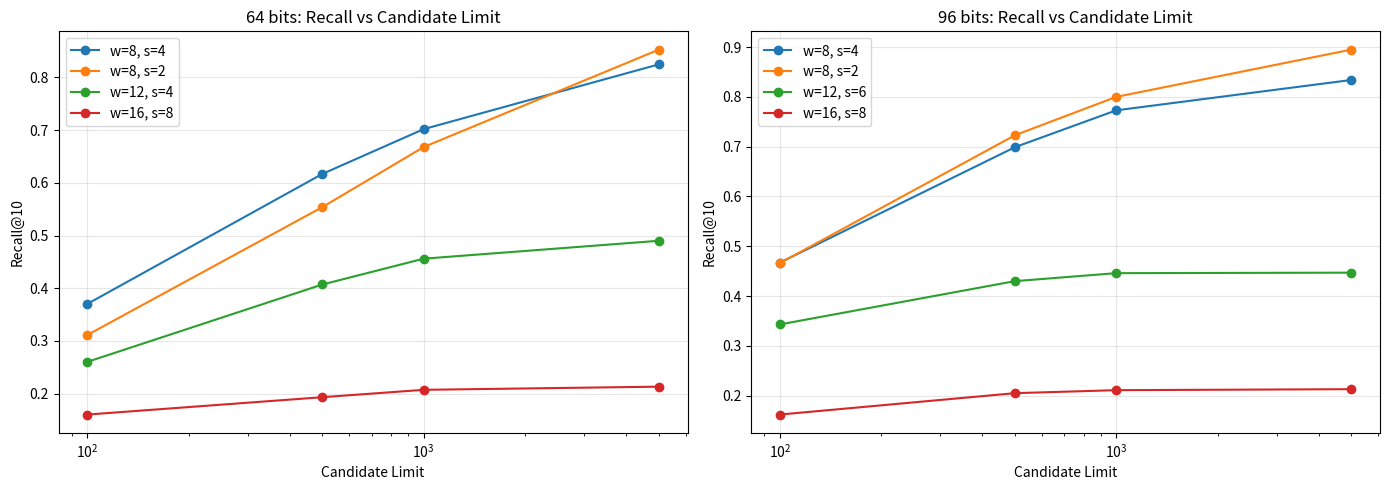

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 64 bits
ax1 = axes[0]
for i, result in enumerate(results_64):
    label = f"w={result['segment_width']}, s={result['stride']}"
    recalls = [result[f'recall@10_limit{l}'] for l in [100, 500, 1000, 5000]]
    ax1.plot([100, 500, 1000, 5000], recalls, 'o-', label=label)
ax1.set_xlabel('Candidate Limit')
ax1.set_ylabel('Recall@10')
ax1.set_title('64 bits: Recall vs Candidate Limit')
ax1.legend()
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)

# 96 bits
ax2 = axes[1]
for i, result in enumerate(results_96):
    label = f"w={result['segment_width']}, s={result['stride']}"
    recalls = [result[f'recall@10_limit{l}'] for l in [100, 500, 1000, 5000]]
    ax2.plot([100, 500, 1000, 5000], recalls, 'o-', label=label)
ax2.set_xlabel('Candidate Limit')
ax2.set_ylabel('Recall@10')
ax2.set_title('96 bits: Recall vs Candidate Limit')
ax2.legend()
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / '49_overlap_recall_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

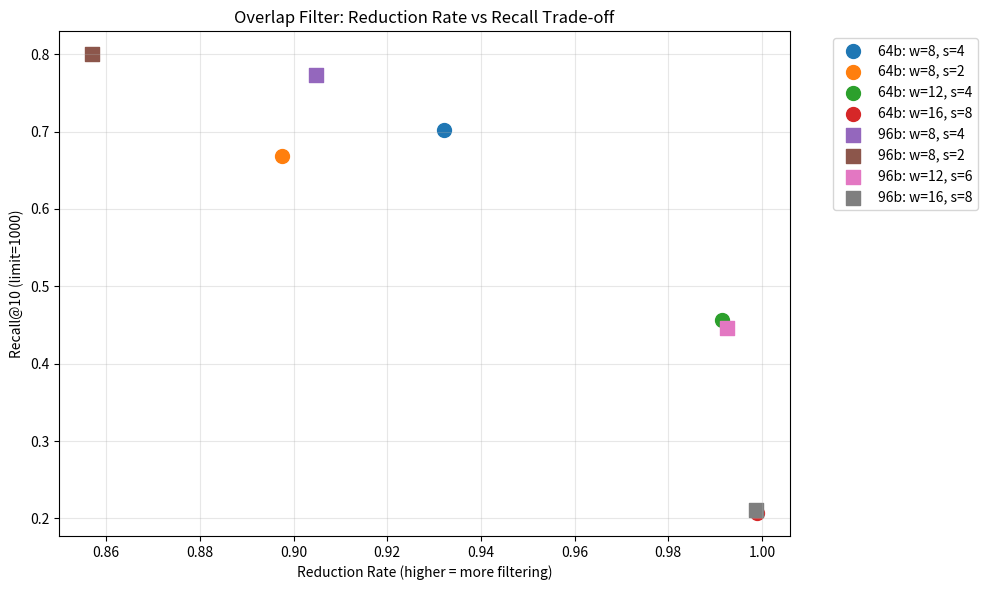

In [12]:
# 削減率 vs Recall のトレードオフ
fig, ax = plt.subplots(figsize=(10, 6))

# 64 bits
for result in results_64:
    label = f"64b: w={result['segment_width']}, s={result['stride']}"
    ax.scatter(result['reduction_rate'], result['recall@10_limit1000'], 
               s=100, marker='o', label=label)

# 96 bits
for result in results_96:
    label = f"96b: w={result['segment_width']}, s={result['stride']}"
    ax.scatter(result['reduction_rate'], result['recall@10_limit1000'], 
               s=100, marker='s', label=label)

ax.set_xlabel('Reduction Rate (higher = more filtering)')
ax.set_ylabel('Recall@10 (limit=1000)')
ax.set_title('Overlap Filter: Reduction Rate vs Recall Trade-off')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / '49_overlap_tradeoff.png', dpi=100, bbox_inches='tight')
plt.show()

## 5. ベースライン比較（Overlapなし）

In [13]:
# Overlapフィルタなし（純粋なハミング距離ソート）でのRecall
def evaluate_baseline(embeddings, hashes, n_queries=100, top_k=10, candidate_limits=[100, 500, 1000, 5000]):
    n_docs = len(embeddings)
    query_indices = np.random.choice(n_docs, n_queries, replace=False)
    
    # Ground truth
    ground_truth = []
    for q_idx in tqdm(query_indices, desc="Ground truth"):
        sims = embeddings @ embeddings[q_idx]
        sims[q_idx] = -1
        top_indices = np.argsort(sims)[-top_k:][::-1]
        ground_truth.append(set(top_indices))
    
    # 評価
    recalls = {limit: [] for limit in candidate_limits}
    
    for i, q_idx in enumerate(tqdm(query_indices, desc="Queries")):
        query_hash = hashes[q_idx]
        distances = hamming_distance_batch(query_hash, hashes)
        distances[q_idx] = 999  # 自分自身を除外
        sorted_indices = np.argsort(distances)
        
        for limit in candidate_limits:
            top_candidates = set(sorted_indices[:limit])
            recall = len(top_candidates & ground_truth[i]) / top_k
            recalls[limit].append(recall)
    
    return {f'recall@{top_k}_limit{limit}': np.mean(recalls[limit]) for limit in candidate_limits}

print("Baseline (no overlap filter):")
print("\n64 bits:")
baseline_64 = evaluate_baseline(embeddings, hashes_64)
for k, v in baseline_64.items():
    print(f"  {k}: {v:.1%}")

print("\n96 bits:")
baseline_96 = evaluate_baseline(embeddings, hashes_96)
for k, v in baseline_96.items():
    print(f"  {k}: {v:.1%}")

Baseline (no overlap filter):

64 bits:


Queries: 100%|██████████| 100/100 [00:01<00:00, 51.81it/s]


  recall@10_limit100: 33.5%
  recall@10_limit500: 60.4%
  recall@10_limit1000: 73.8%
  recall@10_limit5000: 93.9%

96 bits:


Queries: 100%|██████████| 100/100 [00:02<00:00, 38.77it/s]

  recall@10_limit100: 43.9%
  recall@10_limit500: 73.2%
  recall@10_limit1000: 82.5%
  recall@10_limit5000: 96.0%


## 6. 結果サマリー

In [14]:
print("="*70)
print("Overlap Evaluation Summary (400k documents)")
print("="*70)

print("\n--- 64 bits ---")
print(f"{'Config':<20} {'Segments':>10} {'Candidates':>12} {'Reduction':>12} {'Recall@1000':>12}")
print("-"*70)
for r in results_64:
    config = f"w={r['segment_width']}, s={r['stride']}"
    print(f"{config:<20} {r['n_segments']:>10} {r['step1_candidates_mean']:>12.0f} {r['reduction_rate']:>11.1%} {r['recall@10_limit1000']:>11.1%}")
print(f"{'Baseline (no filter)':<20} {'-':>10} {len(embeddings):>12} {'0.0%':>12} {baseline_64['recall@10_limit1000']:>11.1%}")

print("\n--- 96 bits ---")
print(f"{'Config':<20} {'Segments':>10} {'Candidates':>12} {'Reduction':>12} {'Recall@1000':>12}")
print("-"*70)
for r in results_96:
    config = f"w={r['segment_width']}, s={r['stride']}"
    print(f"{config:<20} {r['n_segments']:>10} {r['step1_candidates_mean']:>12.0f} {r['reduction_rate']:>11.1%} {r['recall@10_limit1000']:>11.1%}")
print(f"{'Baseline (no filter)':<20} {'-':>10} {len(embeddings):>12} {'0.0%':>12} {baseline_96['recall@10_limit1000']:>11.1%}")

Overlap Evaluation Summary (400k documents)

--- 64 bits ---
Config                 Segments   Candidates    Reduction  Recall@1000
----------------------------------------------------------------------
w=8, s=4                     15        27053       93.2%       70.2%
w=8, s=2                     29        40842       89.8%       66.8%
w=12, s=4                    14         3381       99.2%       45.6%
w=16, s=8                     7          457       99.9%       20.7%
Baseline (no filter)          -       399029         0.0%       73.8%

--- 96 bits ---
Config                 Segments   Candidates    Reduction  Recall@1000
----------------------------------------------------------------------
w=8, s=4                     23        37993       90.5%       77.3%
w=8, s=2                     45        57032       85.7%       80.0%
w=12, s=6                    15         3010       99.2%       44.6%
w=16, s=8                    11          519       99.9%       21.1%
Baseline (no fil

## 7. 128 bits 追加評価

96b + (8,2) と 128b + (8,4) の比較のため、128 bits ITQ を学習して評価します。

In [16]:
# 128 bits ITQ学習
ITQ_128_PATH = DATA_DIR / "itq_e5_base_128bits.pkl"

if ITQ_128_PATH.exists():
    print("Loading existing 128 bits ITQ model...")
    itq_128 = ITQLSH.load(str(ITQ_128_PATH))
else:
    print("Training 128 bits ITQ model...")
    start_time = time.time()
    itq_128 = ITQLSH(n_bits=128, n_iterations=50, seed=42)
    itq_128.fit(embeddings)
    print(f"Training time: {time.time() - start_time:.1f}s")
    
    # 保存
    itq_128.save(str(ITQ_128_PATH))
    print(f"Saved: {ITQ_128_PATH}")

print(f"ITQ 128 bits: {itq_128.n_bits} bits")

Training 128 bits ITQ model...
ITQ学習開始: samples=399029, dim=768, bits=128
  Centering完了: mean_norm=0.8698
  PCA完了: explained_variance=65.31%
  ITQ iteration 10: quantization_error=0.9442
  ITQ iteration 20: quantization_error=0.9439
  ITQ iteration 30: quantization_error=0.9438
  ITQ iteration 40: quantization_error=0.9437
  ITQ iteration 50: quantization_error=0.9437
ITQ学習完了
Training time: 21.6s
Saved: ../data/itq_e5_base_128bits.pkl
ITQ 128 bits: 128 bits


In [17]:
# 128 bits ハッシュ生成
HASH_128_PATH = DATA_DIR / "wikipedia_400k_e5_base_hashes_128bits.npy"

if HASH_128_PATH.exists():
    print("Loading existing 128 bits hashes...")
    hashes_128 = np.load(HASH_128_PATH)
else:
    print("Generating 128 bits hashes...")
    start_time = time.time()
    hashes_128 = itq_128.transform(embeddings)
    print(f"Generation time: {time.time() - start_time:.1f}s")
    
    # 保存
    np.save(HASH_128_PATH, hashes_128)
    print(f"Saved: {HASH_128_PATH}")

print(f"Hashes 128 bits: {hashes_128.shape}")

Generating 128 bits hashes...
Generation time: 0.4s
Saved: ../data/wikipedia_400k_e5_base_hashes_128bits.npy
Hashes 128 bits: (399029, 128)


In [18]:
# 128 bits Overlap評価
configs_128 = [
    {'segment_width': 8, 'stride': 4},   # 31 segments - 96b(8,2)との比較用
    {'segment_width': 8, 'stride': 2},   # 61 segments
]

print("="*60)
print("128 bits Overlap Evaluation")
print("="*60)

results_128 = []
for config in configs_128:
    print(f"\nConfig: width={config['segment_width']}, stride={config['stride']}")
    result = evaluate_overlap_config(
        embeddings, hashes_128, itq_128,
        segment_width=config['segment_width'],
        stride=config['stride'],
        n_queries=100,
        top_k=10
    )
    results_128.append(result)
    
    print(f"  Segments: {result['n_segments']}")
    print(f"  Step1 candidates: {result['step1_candidates_mean']:.0f} (median: {result['step1_candidates_median']:.0f})")
    print(f"  Reduction rate: {result['reduction_rate']:.1%}")
    print(f"  Recall@10 (limit=1000): {result['recall@10_limit1000']:.1%}")

128 bits Overlap Evaluation

Config: width=8, stride=4
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 23.30it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:00<00:00, 130.76it/s]


  Segments: 31
  Step1 candidates: 49938 (median: 49432)
  Reduction rate: 87.5%
  Recall@10 (limit=1000): 83.7%

Config: width=8, stride=2
  Computing ground truth for 100 queries...


  Ground truth: 100%|██████████| 100/100 [00:04<00:00, 22.60it/s]


  Evaluating overlap filter...


  Queries: 100%|██████████| 100/100 [00:01<00:00, 91.95it/s]

  Segments: 61
  Step1 candidates: 71020 (median: 70380)
  Reduction rate: 82.2%
  Recall@10 (limit=1000): 86.0%


In [19]:
# 128 bits ベースライン
print("128 bits Baseline (no overlap filter):")
baseline_128 = evaluate_baseline(embeddings, hashes_128)
for k, v in baseline_128.items():
    print(f"  {k}: {v:.1%}")

128 bits Baseline (no overlap filter):


Queries: 100%|██████████| 100/100 [00:03<00:00, 32.30it/s]

  recall@10_limit100: 57.3%
  recall@10_limit500: 79.7%
  recall@10_limit1000: 88.8%
  recall@10_limit5000: 98.1%


In [20]:
# 96b vs 128b 比較サマリー
print("="*70)
print("96 bits vs 128 bits 比較")
print("="*70)

print(f"\n{'設定':<25} {'Segments':>10} {'Candidates':>12} {'Reduction':>12} {'Recall@1000':>12}")
print("-"*75)

# 96 bits (8,2)
r = results_96[1]  # w=8, s=2
print(f"{'96b + (8,2)':<25} {r['n_segments']:>10} {r['step1_candidates_mean']:>12.0f} {r['reduction_rate']:>11.1%} {r['recall@10_limit1000']:>11.1%}")

# 128 bits (8,4)
r = results_128[0]  # w=8, s=4
print(f"{'128b + (8,4)':<25} {r['n_segments']:>10} {r['step1_candidates_mean']:>12.0f} {r['reduction_rate']:>11.1%} {r['recall@10_limit1000']:>11.1%}")

# 128 bits (8,2)
r = results_128[1]  # w=8, s=2
print(f"{'128b + (8,2)':<25} {r['n_segments']:>10} {r['step1_candidates_mean']:>12.0f} {r['reduction_rate']:>11.1%} {r['recall@10_limit1000']:>11.1%}")

print("-"*75)
print(f"{'96b Baseline':<25} {'-':>10} {len(embeddings):>12} {'0.0%':>12} {baseline_96['recall@10_limit1000']:>11.1%}")
print(f"{'128b Baseline':<25} {'-':>10} {len(embeddings):>12} {'0.0%':>12} {baseline_128['recall@10_limit1000']:>11.1%}")

96 bits vs 128 bits 比較

設定                          Segments   Candidates    Reduction  Recall@1000
---------------------------------------------------------------------------
96b + (8,2)                       45        57032       85.7%       80.0%
128b + (8,4)                      31        49938       87.5%       83.7%
128b + (8,2)                      61        71020       82.2%       86.0%
---------------------------------------------------------------------------
96b Baseline                       -       399029         0.0%       82.5%
128b Baseline                      -       399029         0.0%       88.8%


## 7. 評価・結論

## 実験結果・評価

### 主要な発見

#### 1. Overlapフィルタは40万件規模で有効に機能
- 実験47（5000件）では全件がStep1候補になり機能しなかったが、40万件では削減効果を確認
- 8ビットセグメントで85〜93%の削減率を達成

#### 2. 96 bits が 64 bits より優れた性能
| 設定 | 64 bits Recall@1000 | 96 bits Recall@1000 | 差分 |
|------|---------------------|---------------------|------|
| Baseline (no filter) | 73.8% | 82.5% | +8.7pt |
| w=8, s=4 | 70.2% | 77.3% | +7.1pt |
| w=8, s=2 | 66.8% | 80.0% | +13.2pt |

#### 3. 最適設定の推奨

**バランス重視: 96 bits + w=8, s=2**
- 削減率: 85.7%（399k → 57k件）
- Recall@1000: 80.0%（ベースライン82.5%から-2.5pt）
- 候補数を約1/7に削減しつつ、高いRecallを維持

**高削減率重視: 64 bits + w=8, s=4**
- 削減率: 93.2%（399k → 27k件）
- Recall@1000: 70.2%（ベースライン73.8%から-3.6pt）
- 候補数を約1/15に削減

#### 4. セグメント幅の影響
- **8ビット**: 最も良いRecall/削減率バランス
- **12ビット以上**: 削減率99%超だがRecall大幅低下（45%以下）→ **非推奨**

### 結論

1. **96 bits + Overlap(8,2)** が推奨設定
   - 85.7%の候補削減でRecall 80%を維持
   - ベースラインからのRecall低下は2.5ptのみ

2. **64 bits でも実用可能**
   - Overlap(8,4)で93.2%削減、Recall 70.2%
   - ストレージ重視の場合に選択肢

3. **Overlapフィルタの効果**
   - 大規模データ（40万件）で初めて有効に機能
   - 候補削減により後段の処理（リランキング等）の負荷を軽減可能

### 次のステップ
- 3段階カスケード（Overlap → ハミング距離 → コサイン類似度）の評価
- 実際の検索遅延の計測
- 異なるデータセット（英語Wikipedia等）での汎化性検証